# Activity: Explore sampling

## Introduction
In this activity, you will engage in effective sampling of a dataset in order to make it easier to analyze. As a data professional you will often work with extremely large datasets, and utilizing proper sampling techniques helps you improve your efficiency in this work. 

For this activity, you are a member of an analytics team for the Environmental Protection Agency. You are assigned to analyze data on air quality with respect to carbon monoxide—a major air pollutant—and report your findings. The data utilized in this activity includes information from over 200 sites, identified by their state name, county name, city name, and local site name. You will use effective sampling within this dataset. 

## Step 1: Imports

### Import packages

Import `pandas`,  `numpy`, `matplotlib`, `statsmodels`, and `scipy`. 

In [1]:
# Import packages
# Import the relevant Python libraries and modules needed in this lab.

### YOUR CODE HERE ###
# Import libraries and packages

# Import packages
from google.cloud import storage

import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
from io import StringIO
from io import BytesIO
import json
import pickle
import six
import charset_normalizer
from wordcloud import WordCloud 
from typing import List

from scipy import stats
import statsmodels.api as sm

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
#storage_client =  storage.Client.from_service_account_json('../heidless-jupyter-0-d2008100d98c.json')
storage_client =  storage.Client()

BUCKET_NAME = 'heidless-jupyter-bucket-0'

bucket = storage_client.get_bucket(BUCKET_NAME)

AllCSV = []
my_prefix = 'air-quality/'
my_file = 'c4_epa_air_quality.csv'
full_file = my_prefix + my_file
#print(f'full_file: {full_file}')

file_names = list(bucket.list_blobs(prefix=my_prefix))
for file in file_names:
    if(file.name != my_prefix):
        if file.name == full_file:
            AllCSV.append(file.name)
#            print(file.name)
AllCSV


['air-quality/c4_epa_air_quality.csv']

In [3]:
# RUN THIS CELL TO IMPORT YOUR DATA.

### YOUR CODE HERE ###
#companies = pd.read_csv("Unicorn_Companies.csv")

# Display the first 10 rows of the data
all_dataframes = []

for csv in AllCSV:
    blob = bucket.get_blob(csv)
    if blob is not None and blob.exists(storage_client):
        bt = blob.download_as_string()
        s = str(bt, 'ISO-8859-1')
        s = StringIO(s)
        df = pd.read_csv(s, encoding='ISO-8859-1', low_memory=False)

        #df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
        all_dataframes.append(df)
        print(csv)
    
#all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

epa_data = all_dataframes[0]
epa_data.head()


air-quality/c4_epa_air_quality.csv


,Unnamed: 0,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,arithmetic_mean,aqi
0,0,2018-01-01,Arizona,Maricopa,Buckeye,BUCKEYE,Carbon monoxide,Parts per million,0.473684,7
1,1,2018-01-01,Ohio,Belmont,Shadyside,Shadyside,Carbon monoxide,Parts per million,0.263158,5
2,2,2018-01-01,Wyoming,Teton,Not in a city,Yellowstone National Park - Old Faithful Snow ...,Carbon monoxide,Parts per million,0.111111,2
3,3,2018-01-01,Pennsylvania,Philadelphia,Philadelphia,North East Waste (NEW),Carbon monoxide,Parts per million,0.300000,3
4,4,2018-01-01,Iowa,Polk,Des Moines,CARPENTER,Carbon monoxide,Parts per million,0.215789,3


# Import libraries and packages

### YOUR CODE HERE ###

### Load the dataset

As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

# RUN THIS CELL TO IMPORT YOUR DATA.

### YOUR CODE HERE ###
epa_data = pd.read_csv("c4_epa_air_quality.csv", index_col = 0)

<details>
  <summary><h4>Hint 1</h4></summary>

Use the function in the `pandas` library that allows you to read in data from a csv file and load it into a DataFrame. 

</details>

<details>
  <summary><h4>Hint 2</h4></summary>

Use the `read_csv` function from the pandas `library`. Set the `index_col` parameter to `0` to read in the first column as an index (and to avoid `"Unnamed: 0"` appearing as a column in the resulting Dataframe).

</details>

## Step 2: Data exploration

### Examine the data

To understand how the dataset is structured, examine the first 10 rows of the data.

In [8]:
# First 10 rows of the data

### YOUR CODE HERE ###
epa_data.head(10)

,Unnamed: 0,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,arithmetic_mean,aqi
0,0,2018-01-01,Arizona,Maricopa,Buckeye,BUCKEYE,Carbon monoxide,Parts per million,0.473684,7
1,1,2018-01-01,Ohio,Belmont,Shadyside,Shadyside,Carbon monoxide,Parts per million,0.263158,5
2,2,2018-01-01,Wyoming,Teton,Not in a city,Yellowstone National Park - Old Faithful Snow ...,Carbon monoxide,Parts per million,0.111111,2
3,3,2018-01-01,Pennsylvania,Philadelphia,Philadelphia,North East Waste (NEW),Carbon monoxide,Parts per million,0.300000,3
4,4,2018-01-01,Iowa,Polk,Des Moines,CARPENTER,Carbon monoxide,Parts per million,0.215789,3
5,5,2018-01-01,Hawaii,Honolulu,Not in a city,Kapolei,Carbon monoxide,Parts per million,0.994737,14
6,6,2018-01-01,Hawaii,Honolulu,Not in a city,Kapolei,Carbon monoxide,Parts per million,0.200000,2
7,7,2018-01-01,Pennsylvania,Erie,Erie,NaN,Carbon monoxide,Parts per million,0.200000,2
8,8,2018-01-01,Hawaii,Honolulu,Honolulu,Honolulu,Carbon monoxide,Parts per million,0.400000,5
9,9,2018-01-01,Colorado,Larimer,Fort Collins,Fort Collins - CSU - S. Mason,Carbon monoxide,Parts per million,0.300000,6


<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Use the function in the `pandas` library that allows you to get a specific number of rows from the top of a DataFrame. 

</details>

<details>
  <summary><h4><strong> Hint 2 </STRONG></h4></summary>

Use the `head` function from the `pandas` library. Set the `n` parameter to `10` to print out the first 10 rows.

</details>

**Question:** What does the `aqi` column represent?

[Write your response here. Double-click (or enter) to edit.]

### Generate a table of descriptive statistics

Generate a table of some descriptive statistics about the data. Specify that all columns of the input be included in the output.

In [9]:
### YOUR CODE HERE ###
epa_data.describe(include='all')

,Unnamed: 0,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,arithmetic_mean,aqi
count,260.000000,260,260,260,260,257,260,260,260.000000,260.000000
unique,NaN,1,52,149,190,253,1,1,NaN,NaN
top,NaN,2018-01-01,California,Los Angeles,Not in a city,Kapolei,Carbon monoxide,Parts per million,NaN,NaN
freq,NaN,260,66,14,21,2,260,260,NaN,NaN
mean,129.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.403169,6.757692
std,75.199734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317902,7.061707
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,64.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200000,2.000000
50%,129.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.276315,5.000000
75%,194.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516009,9.000000


<details>
  <summary><h4>Hint 1</h4></summary>

Use function in the `pandas` library that allows you to generate a table of basic descriptive statistics in a DataFrame.

</details>

<details>
  <summary><h4>Hint 2</h4></summary>

Use the `describe` function from the `pandas` library. Set the `include` parameter passed in to this function to 'all' to specify that all columns of the input be included in the output.

</details>

**Question:** Based on the preceding table of descriptive statistics, what is the mean value of the `aqi` column? 

[Write your response here. Double-click (or enter) to edit.]

**Question:** Based on the preceding table of descriptive statistics, what do you notice about the count value for the `aqi` column?

[Write your response here. Double-click (or enter) to edit.]

### Use the `mean()` function on the `aqi`  column

Now, use the `mean()` function on the `aqi`  column and assign the value to a variable `population_mean`. The value should be the same as the one generated by the `describe()` method in the above table. 

In [11]:
### YOUR CODE HERE ###
population_mean = epa_data['aqi'].mean()
population_mean

6.757692307692308

<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Use the function in the `pandas` library that allows you to generate a mean value for a column in a DataFrame.

</details>

<details>
  <summary><h4><strong> Hint 2 </STRONG></h4></summary>

Use the `mean()` method.

</details>

## Step 3: Statistical tests

### Sample with replacement

First, name a new variable `sampled_data`. Then, use the `sample()` dataframe method to draw 50 samples from `epa_data`. Set `replace` equal to `'True'` to specify sampling with replacement. For `random_state`, choose an arbitrary number for random seed. Make that arbitrary number `42`.

In [14]:
### YOUR CODE HERE ###
sampled_data = epa_data.sample(n=50, replace=True, random_state=42)
sampled_data.head(10)

,Unnamed: 0,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,arithmetic_mean,aqi
102,102,2018-01-01,Texas,Harris,Houston,Clinton,Carbon monoxide,Parts per million,0.157895,2
106,106,2018-01-01,California,Imperial,Calexico,Calexico-Ethel Street,Carbon monoxide,Parts per million,1.183333,26
71,71,2018-01-01,Alabama,Jefferson,Birmingham,Arkadelphia/Near Road,Carbon monoxide,Parts per million,0.200000,2
188,188,2018-01-01,Arizona,Maricopa,Tempe,Diablo,Carbon monoxide,Parts per million,0.542105,10
20,20,2018-01-01,Virginia,Roanoke,Vinton,East Vinton Elementary School,Carbon monoxide,Parts per million,0.100000,1
102,102,2018-01-01,Texas,Harris,Houston,Clinton,Carbon monoxide,Parts per million,0.157895,2
121,121,2018-01-01,North Carolina,Mecklenburg,Charlotte,Garinger High School,Carbon monoxide,Parts per million,0.200000,2
214,214,2018-01-01,Florida,Broward,Davie,Daniela Banu NCORE,Carbon monoxide,Parts per million,0.273684,5
87,87,2018-01-01,California,Humboldt,Eureka,Jacobs,Carbon monoxide,Parts per million,0.393750,5
99,99,2018-01-01,California,Santa Barbara,Goleta,Goleta,Carbon monoxide,Parts per million,0.222222,3


### Output the first 10 rows

Output the first 10 rows of the DataFrame. 

In [ ]:
### YOUR CODE HERE ###
sampled_data.head()

<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Use the function in the `pandas` library that allows you to get a specific number of rows from the top of a DataFrame. 

</details>

<details>
  <summary><h4><strong> Hint 2 </STRONG></h4></summary>

Use the `head` function from the `pandas` library. Set the `n` parameter to `10` to print out the first 10 rows.

</details>

**Question:** In the DataFrame output, why is the row index 102 repeated twice? 

[Write your response here. Double-click (or enter) to edit.]

**Question:** What does `random_state` do?

[Write your response here. Double-click (or enter) to edit.]

### Compute the mean value from the `aqi` column

Compute the mean value from the `aqi` column in `sampled_data` and assign the value to the variable `sample_mean`.

In [16]:
### YOUR CODE HERE ###
sample_mean = sampled_data['aqi'].mean()
sample_mean

5.54

 **Question:**  Why is `sample_mean` different from `population_mean`?


[Write your response here. Double-click (or enter) to edit.]

### Apply the central limit theorem

Imagine repeating the the earlier sample with replacement 10,000 times and obtaining 10,000 point estimates of the mean. In other words, imagine taking 10,000 random samples of 50 AQI values and computing the mean for each sample. According to the **central limit theorem**, the mean of a sampling distribution should be roughly equal to the population mean. Complete the following steps to compute the mean of the sampling distribution with 10,000 samples. 

* Create an empty list and assign it to a variable called `estimate_list`. 
* Iterate through a `for` loop 10,000 times. To do this, make sure to utilize the `range()` function to generate a sequence of numbers from 0 to 9,999. 
* In each iteration of the loop, use the `sample()` function to take a random sample (with replacement) of 50 AQI values from the population. Do not set `random_state` to a value.
* Use the list `append()` function to add the value of the sample `mean` to each item in the list.


In [18]:
### YOUR CODE HERE ###
estimate_list = []
for i in range(10000):
    estimate_list.append(epa_data['aqi'].sample(n=50, replace=True).mean())


<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Review [the content about sampling in Python](https://www.coursera.org/learn/the-power-of-statistics/lecture/SNOE0/sampling-distributions-with-python). 

</details>

### Create a new DataFrame

Next, create a new DataFrame from the list of 10,000 estimates. Name the new variable `estimate_df`.

In [20]:
### YOUR CODE HERE ###
estimate_df = pd.DataFrame(data={'estimate': estimate_list})
estimate_df.head(10)

,estimate
0,4.86
1,6.94
2,5.50
3,7.54
4,8.40
5,5.80
6,5.60
7,7.36
8,5.12
9,6.82


<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Review [the content about sampling in Python](https://www.coursera.org/learn/the-power-of-statistics/lecture/SNOE0/sampling-distributions-with-python). 

</details>

<details>
<summary><h4><strong> Hint 2 </STRONG></h4></summary>

Use the `mean()` function.

</details>

### Compute the mean() of the sampling distribution

Next, compute the `mean()` of the sampling distribution of 10,000 random samples and store the result in a new variable `mean_sample_means`.

In [22]:
### YOUR CODE HERE ###
mean_sample_means = estimate_df['estimate'].mean()
mean_sample_means

6.765286

<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Use the function in the `pandas` library that allows you to generate a mean value for a column in a DataFrame.

</details>

<details>
  <summary><h4><strong> Hint 2 </STRONG></h4></summary>

Use the `mean()` function.

</details>

**Question:** What is the mean for the sampling distribution of 10,000 random samples?

[Write your response here. Double-click (or enter) to edit.]

<details>
  <summary><h4><strong> Hint 3 </STRONG></h4></summary>

This value is contained in `mean_sample_means`.

</details>

<details>
  <summary><h4><strong> Hint 4 </STRONG></h4></summary>

According to the central limit theorem, the mean of the preceding sampling distribution should be roughly equal to the population mean. 

</details>

**Question:** How are the central limit theorem and random sampling (with replacement) related?

[Write your response here. Double-click (or enter) to edit.]

### Output the distribution using a histogram

Output the distribution of these estimates using a histogram. This provides an idea of the sampling distribution.

<Axes: >

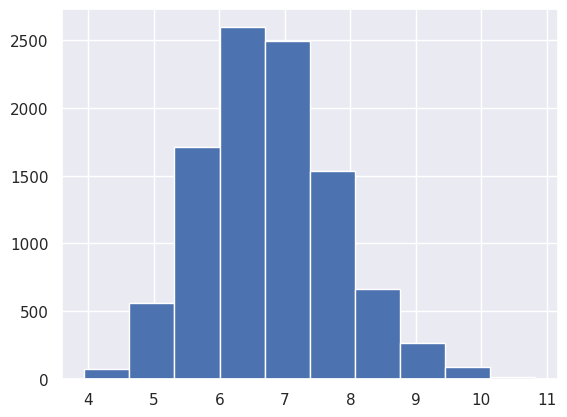

In [23]:
### YOUR CODE HERE ###
estimate_df['estimate'].hist()

<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Use the `hist()` function. 

</details>

### Calculate the standard error

Calculate the standard error of the mean AQI using the initial sample of 50. The **standard error** of a statistic measures the sample-to-sample variability of the sample statistic. It provides a numerical measure of sampling variability and answers the question: How far is a statistic based on one particular sample from the actual value of the statistic?

In [24]:
### YOUR CODE HERE ###
standard_error = estimate_df['estimate'].std()
standard_error

1.009662260358383

<details>
  <summary><h4><strong> Hint 1 </STRONG></h4></summary>

Use the `std()` function and the `np.sqrt()` function.

</details>

## Step 4: Results and evaluation

###  Visualize the relationship between the sampling and normal distributions

Visualize the relationship between your sampling distribution of 10,000 estimates and the normal distribution.

1. Plot a histogram of the 10,000 sample means 
2. Add a vertical line indicating the mean of the first single sample of 50
3. Add another vertical line indicating the mean of the means of the 10,000 samples 
4. Add a third vertical line indicating the mean of the actual population

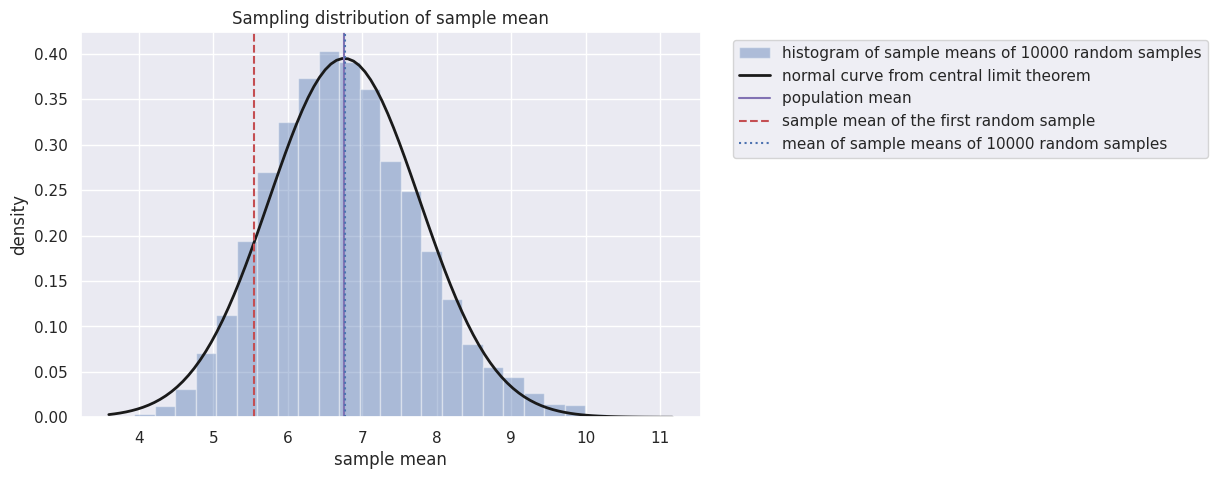

In [35]:
 ### YOUE CODE HERE ###
plt.figure(figsize=(8,5))
plt.hist(estimate_df['estimate'], bins=25, density=True, alpha=0.4, label = "histogram of sample means of 10000 random samples")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) # generate a grid of 100 values from xmin to xmax.
p = stats.norm.pdf(x, population_mean, standard_error)
plt.plot(x, p, 'k', linewidth=2, label = 'normal curve from central limit theorem')
plt.axvline(x=population_mean, color='m', linestyle = 'solid', label = 'population mean')
plt.axvline(x=sample_mean, color='r', linestyle = '--', label = 'sample mean of the first random sample')
plt.axvline(x=mean_sample_means, color='b', linestyle = ':', label = 'mean of sample means of 10000 random samples')
plt.title("Sampling distribution of sample mean")
plt.xlabel('sample mean')
plt.ylabel('density')
plt.legend(bbox_to_anchor=(1.04,1));


**Question:** What insights did you gain from the preceding sampling distribution?

[Write your response here. Double-click (or enter) to edit.]

# Considerations

**What are some key takeaways that you learned from this lab?**

**What findings would you share with others?**

**What would you convey to external stakeholders?**




**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.